# imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2022-09-09 16:44:54.549371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 16:44:54.549396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/lscr/.pyenv/versions/3.8.12/envs/tfdc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train, val = tfds.load(name='mnist', split=['train', 'test'], as_supervised=True, batch_size=-1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2022-09-09 16:44:58.287398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 16:44:58.288968: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 16:44:58.289010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2022-09-09 16:44:58.290261: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [3]:
train_images, train_labels = tfds.as_numpy(train)
val_images, val_labels = tfds.as_numpy(val)

train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [4]:
len(np.unique(train_labels)), len(np.unique(val_labels))

(10, 10)

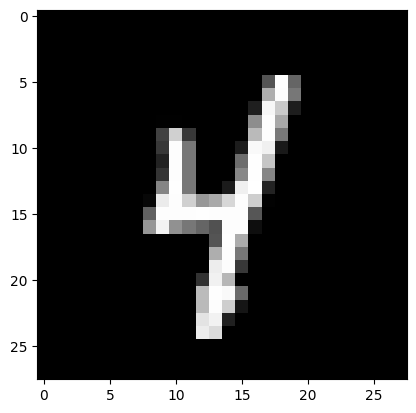

In [5]:
plt.imshow(tf.squeeze(train_images[0]), cmap='gray')

# Params

In [6]:
NUM_CLASSES = len(np.unique(train_labels))

N_TRAIN_SAMPLES = train_images.shape[0]
N_VAL_SAMPLES = val_images.shape[0]

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32

TRAIN_STEPS = int(N_TRAIN_SAMPLES / TRAIN_BATCH_SIZE)
VAL_STEPS = int(N_VAL_SAMPLES / VAL_BATCH_SIZE)

# ImageDataGenerator

In [54]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1 / 255.) # AUGMENT HERE
train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=TRAIN_BATCH_SIZE)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
val_generator = val_datagen.flow(x=val_images, y=val_labels, batch_size=VAL_BATCH_SIZE_SIZE)

# Callbacks

In [76]:
# Basic ES
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [71]:
des_train_acc = 0.99
des_val_acc = 0.95
# Custom ES
class MyEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > des_train_acc:
            self.stop_training = True

# Model

In [77]:
# model 

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
 dense_11 (Dense)            (None, 64)               

In [78]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [79]:
history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=TRAIN_STEPS,
                    validation_data=val_generator,
                    validation_steps=VAL_STEPS,
                   callbacks=[es])

Epoch 1/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1346 - accuracy: 0.9588 - val_loss: 0.0514 - val_accuracy: 0.9829
Epoch 2/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0460 - accuracy: 0.9855 - val_loss: 0.0392 - val_accuracy: 0.9866
Epoch 3/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0413 - val_accuracy: 0.9874
Epoch 4/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0338 - val_accuracy: 0.9885
Epoch 5/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0326 - val_accuracy: 0.9890
Epoch 6/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 7/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0385 - 

# Visualise

In [80]:
import pandas as pd

def learning_curves(history):
    '''Creates a n * max(m, 3) set of plots of learning curves for each metric logged. Requires a validation set.'''
    # Put metrics from history.history in a data frame
    metrics = pd.DataFrame(dict(history.history))
    epochs = np.arange(1, metrics.shape[0] + 1, 1)

    # Determine size of plot based
    if len(metrics.columns) > 3:
        n_rows = int((len(metrics.columns) / 2 - 1) // 3 + 1)
        n_col = 3
    n_rows = 1
    n_cols = int(len(metrics.columns) / 2)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))

    # Determine pairs from dictionary
    pairs = []
    for i, metric in enumerate(metrics.columns, 1):
        if i <= metrics.shape[1] / 2:
            pairs.append([column for column in metrics.columns if metric in column])

    # Plot pairs
    for i, pair in enumerate(pairs):
        axes[i].plot(epochs, metrics[pair[0]], label=pair[0])
        axes[i].plot(epochs, metrics[pair[1]], label=pair[1])
        axes[i].set_title(f'Training and Validation {pair[0].title()}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(pair[0].title())
        axes[i].legend()
    
    fig.suptitle('Learning Curves', fontsize=20)
    plt.show()

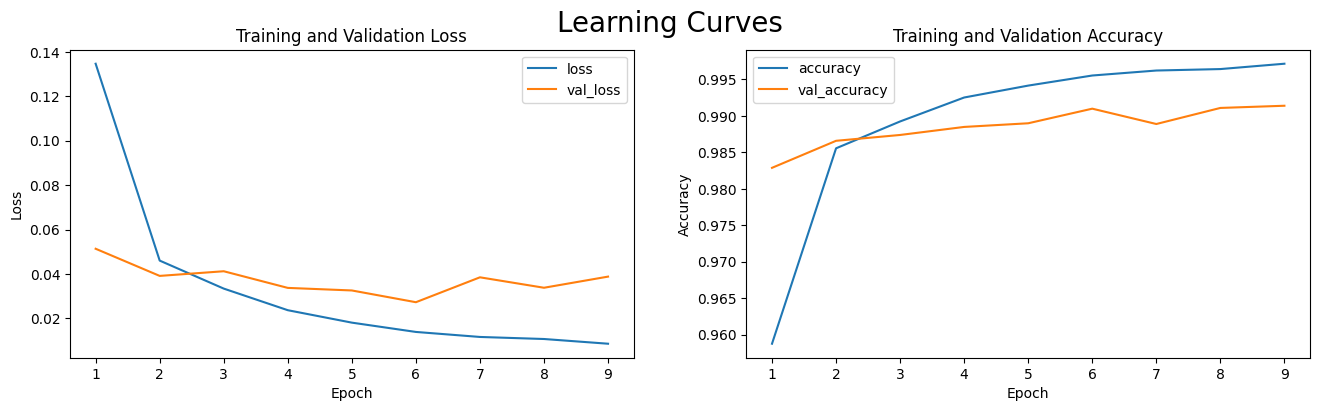

In [81]:
learning_curves(history)

In [92]:
history.history['loss'][-1], history.history['val_loss'][-1], history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.008638568222522736,
 0.038838718086481094,
 0.9971500039100647,
 0.9913862347602844)

# Save

In [93]:
model.save('simple_CNN.h5', save_format='h5')